# Climate stripes demonstrated in a notebook

In [1]:
#!pip install -r requirements.txt

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import fsspec
from convertbng.util import convert_bng

RAL_LAT, RAL_LON = 51.570664384, -1.308832098

fpath = index_uri = "haduk-grid1.json"


def check_location_is_near(lat, lon, point_ds, ds, threshold=0.05):
    """
    Checks that selected eastings and northings (in BNG coordinates) are within the lat/lon threshold of
    the `lat` and `lon` requested by the user.

    Raises an exception if outside the acceptable threshold.

    Returns tuple of: (eastings, northings)
    """
    y = float(point_ds.projection_y_coordinate.values)
    x = float(point_ds.projection_x_coordinate.values)
    
    lat_diff = abs(float(ds.latitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lat)
    lon_diff = abs(float(ds.longitude.sel(projection_y_coordinate=y, projection_x_coordinate=x)) - lon)

    assert lat_diff < threshold, f"Lat diff is too big: {lat_diff}"
    assert lon_diff < threshold, f"Lon diff is too big: {lon_diff}"

    return (x, y)


def extract_time_series_at_location(lat=RAL_LAT, lon=RAL_LON, ref_period=(1901, 2000)):
    ref_period = tuple([str(dt) for dt in ref_period])
    compression = "zstd" if index_uri.split(".")[-1].startswith("zst") else None
    mapper = fsspec.get_mapper("reference://", fo=index_uri, target_options={"compression": compression})

    print("opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each")
    ds = xr.open_zarr(mapper, consolidated=False, use_cftime=True, decode_timedelta=False)

    print("convert to northings, eastings...")
    requested_eastings, requested_northings = [i[0] for i in convert_bng(lon, lat)] 
             #lat_lon_to_eastings_northings(lon, lat)
 
    print("extract nearest grid point...")
    temp_series = ds.tas.sel(projection_y_coordinate=requested_northings, projection_x_coordinate=requested_eastings, method="nearest")

    # Check the chosen location is near the requested location
    actual_eastings, actual_northings = check_location_is_near(lat, lon, temp_series, ds)

    # Get mean over reference period
    reference_mean = temp_series.sel(time=slice(*ref_period)).mean()

    # Construct content to return
    response = {
        "temp_series": temp_series.squeeze(),
        "demeaned_temp_series": (temp_series - reference_mean).squeeze(),
        "eastings": actual_eastings, "northings": actual_northings,
        "lat": float(ds.latitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings)),
        "lon": float(ds.longitude.sel(projection_y_coordinate=actual_northings, projection_x_coordinate=actual_eastings))
    }
    print("Returning data objects...")
    return response

In [87]:
def get_colour_map(cmap_name="RdBu_r", n_colours=-1):
    args = [cmap_name]
    if n_colours > 1: 
        args.append(n_colours)

    cmap = plt.get_cmap(*args)
    cmap._init()
    return cmap

opening kerchunk...need bigger arrays and specify duplicate coords and lat lon from each
convert to northings, eastings...
extract nearest grid point...
Returning data objects...
Downloaded data...
Starting plot


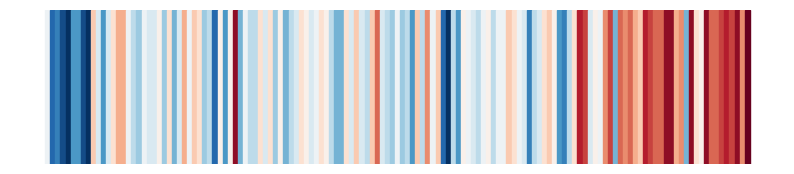

In [109]:
def rgba_to_hex(r, g, b, a=None):
    r, g, b = [int(i * 255) for i in (r, g, b)]
    return "#" + "".join([("0" + hex(i).split("x")[1])[-2:] for i in (r, g, b)])


def plot_climate_stripes_uk_location(lat, lon, n_colours=-1, cmap_name="RdBu_r"):
    resp = extract_time_series_at_location(lat, lon)
    years = resp["temp_series"].time.dt.year
    
    actual_values = resp["temp_series"].values
    stripes_data = resp["demeaned_temp_series"].values
    print("Downloaded data...")

    normalised_data = plt.Normalize(stripes_data.min(), stripes_data.max())
    cmap = get_colour_map(cmap_name, n_colours)
    
    fig, ax = plt.subplots(figsize=(10, 2))
    
    print("Starting plot")

    colours = []
    
    for i in range(stripes_data.shape[0]):
        actual_value = actual_values[i]
        year = years[i]
        normalised_value = normalised_data(stripes_data[i])
        rgba_colour = cmap(normalised_value)
        colours.append(rgba_colour)

        # collected.append([actual_value, normalised_value, colour])
        ax.axvspan(
            xmin=i - 0.5, xmax=i + 0.5, color=rgba_colour
        )
    
    ax.axis("off")

    df = pd.DataFrame({
        "years": years,
        "temp_value": actual_values,
        "temp_demeaned": stripes_data,
        "hex_colour": [rgba_to_hex(r, g, b) for (r, g, b, a) in colours],
        "red": [col[0] for col in colours],
        "green": [col[1] for col in colours],
        "blue": [col[2] for col in colours]
    })
        
    return df


df = plot_climate_stripes_uk_location(50.6200, -3.4137, n_colours=20)

In [110]:
df

,years,temp_value,temp_demeaned,hex_colour,red,green,blue
0,1884,10.744388,0.004872,#edf2f5,0.929412,0.950052,0.961404
1,1885,9.848488,-0.891029,#2268ad,0.136429,0.409288,0.679257
2,1886,9.984892,-0.754625,#3480b9,0.206605,0.502167,0.726729
3,1887,9.646891,-1.092626,#134c88,0.077399,0.299690,0.535191
4,1888,9.453665,-1.285852,#053061,0.019608,0.188235,0.380392
...,...,...,...,...,...,...,...
134,2018,11.892818,1.153302,#b31b2c,0.705470,0.108978,0.175645
135,2019,11.709645,0.970128,#c6413e,0.779773,0.257585,0.245820
136,2020,11.950939,1.211423,#8e0c25,0.558720,0.049536,0.146336
137,2021,11.506322,0.766805,#e88b6e,0.913519,0.547368,0.433230


In [113]:
CMAP_NAME = "RdBu_r"
N = 20
cmap = get_colour_map(CMAP_NAME, N)
assert cmap.N == N

cols = [((r, g, b), f"colour_{(i + 1):02d}") for i, (r, g, b, a) in enumerate(cmap._lut)]
print(f"""
There are {N} + 3 colours. 

The last three rows are the colours for data low and high out-of-range values and for masked values.

CHECK WHY COLOURS INCLUDE THOSE LAST 3!!!
""")

print([(key, col) for (col, key) in cols])
col_lookup = dict(cols)



def show_dataframe_with_colours(df, cmap_name=CMAP_NAME):
    df["colour_block"] = ""
    df.loc[:, "colour"] = df.apply(lambda row: col_lookup[(row["red"], row["green"], row["blue"])], axis=1)
    gmap = np.array([df.temp_demeaned]).transpose()
    plt.rcParams["image.cmap"] = cmap_name
    return df.style.background_gradient(axis=None, gmap=gmap, cmap=None, subset=['colour_block'])


show_dataframe_with_colours(df)


There are 20 + 3 colours. 

The last three rows are the colours for data low and high out-of-range values and for masked values.

CHECK WHY COLOURS INCLUDE THOSE LAST 3!!!

[('colour_01', (0.0196078431372549, 0.18823529411764706, 0.3803921568627451)), ('colour_02', (0.0773993808049536, 0.29969040247678025, 0.5351909184726523)), ('colour_03', (0.13642930856553154, 0.4092879256965945, 0.6792569659442725)), ('colour_04', (0.20660474716202276, 0.5021671826625388, 0.7267285861713106)), ('colour_05', (0.295356037151703, 0.5971104231166151, 0.7758513931888545)), ('colour_06', (0.45841073271413846, 0.70030959752322, 0.8315789473684211)), ('colour_07', (0.6115583075335399, 0.7923632610939114, 0.8817337461300311)), ('colour_08', (0.7415892672858619, 0.8584107327141385, 0.9188854489164088)), ('colour_09', (0.8509803921568628, 0.9128998968008257, 0.9469556243550051)), ('colour_10', (0.9294117647058824, 0.9500515995872033, 0.9614035087719298)), ('colour_11', (0.9748194014447884, 0.9397316821465428

,years,temp_value,temp_demeaned,hex_colour,red,green,blue,colour_block,colour
0,1884,10.744388,0.004872,#edf2f5,0.929412,0.950052,0.961404,,colour_10
1,1885,9.848488,-0.891029,#2268ad,0.136429,0.409288,0.679257,,colour_03
2,1886,9.984892,-0.754625,#3480b9,0.206605,0.502167,0.726729,,colour_04
3,1887,9.646891,-1.092626,#134c88,0.077399,0.299690,0.535191,,colour_02
4,1888,9.453665,-1.285852,#053061,0.019608,0.188235,0.380392,,colour_21
5,1889,10.112778,-0.626739,#4b98c5,0.295356,0.597110,0.775851,,colour_05
6,1890,10.118856,-0.620661,#4b98c5,0.295356,0.597110,0.775851,,colour_05
7,1891,9.707666,-1.031851,#134c88,0.077399,0.299690,0.535191,,colour_02
8,1892,9.548828,-1.190688,#053061,0.019608,0.188235,0.380392,,colour_21
9,1893,11.152430,0.412914,#fac9b1,0.981011,0.791950,0.694943,,colour_13


This is what the above looks like when run interactively...

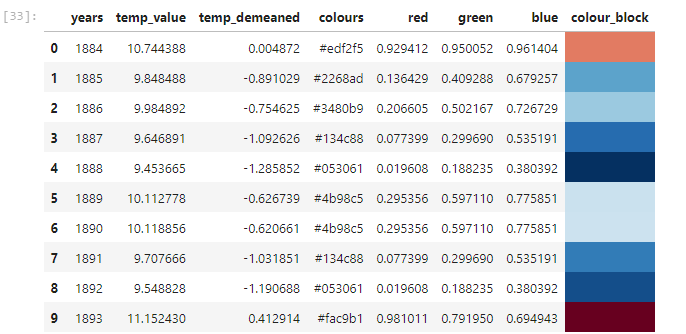

In [115]:
n_colours_used = len(df.colour.unique())
print(f"Number of colours used: {n_colours_used}")

Number of colours used: 20


## Appendices

### Appendix 1: Colour map definitions

You can define a colour map with unlimited (maybe 256 is the limit) colours, or specify your own limit, e.g.:

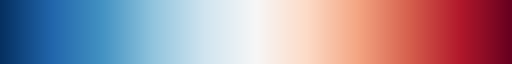

In [116]:
cmap = plt.get_cmap("RdBu_r")
cmap

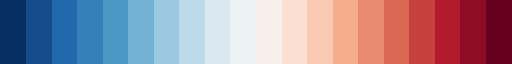

In [117]:
cmap = get_colour_map("RdBu_r", 20)
cmap

In [118]:
for r, g, b, a in cmap._lut: 
    print(r, g, b)

0.0196078431372549 0.18823529411764706 0.3803921568627451
0.0773993808049536 0.29969040247678025 0.5351909184726523
0.13642930856553154 0.4092879256965945 0.6792569659442725
0.20660474716202276 0.5021671826625388 0.7267285861713106
0.295356037151703 0.5971104231166151 0.7758513931888545
0.45841073271413846 0.70030959752322 0.8315789473684211
0.6115583075335399 0.7923632610939114 0.8817337461300311
0.7415892672858619 0.8584107327141385 0.9188854489164088
0.8509803921568628 0.9128998968008257 0.9469556243550051
0.9294117647058824 0.9500515995872033 0.9614035087719298
0.9748194014447884 0.9397316821465428 0.9190918472652219
0.987203302373581 0.8819401444788442 0.8200206398348814
0.9810113519091848 0.7919504643962848 0.6949432404540763
0.9624355005159959 0.6804953560371518 0.5525283797729619
0.9135190918472652 0.5473684210526315 0.43323013415892664
0.8515995872033024 0.40495356037151714 0.32383900928792575
0.7797729618163055 0.2575851393188856 0.2458204334365326
0.7054695562435503 0.108978